Объект GradientTape в TensorFlow

In [ ]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
grad_of_y_wrt_x

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
x = tf.Variable(tf.random.uniform((2, 2)))
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
grad_of_y_wrt_x.numpy()

array([[2., 2.],
       [2., 2.]], dtype=float32)

In [ ]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

In [ ]:
grad_of_y_wrt_W_and_b[0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4664291, 0.4664291],
       [0.5907396, 0.5907396]], dtype=float32)>

In [ ]:
grad_of_y_wrt_W_and_b[1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>

In [ ]:
grad_of_y_wrt_W_and_b

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.4664291, 0.4664291],
        [0.5907396, 0.5907396]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]

#Классификация набора данных MNIST на Keras

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
test_images.shape

(10000, 784)

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer= "rmsprop",#sgd
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.2644 - accuracy: 0.9233
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.1057 - accuracy: 0.9688
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0693 - accuracy: 0.9794
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0505 - accuracy: 0.9848
Epoch 5/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0377 - accuracy: 0.9890


ДОП ЗАДАНИЕ - accuracy тестовой выборки

In [ ]:
results = model.evaluate(train_images, train_labels, batch_size=128)
print("test loss, test acc:", results)

469/469 [==============================] - 3s 6ms/step - loss: 0.0242 - accuracy: 0.9940
test loss, test acc: [0.024228600785136223, 0.9939500093460083]


#Tensorflow 

Простой класс Dense

In [ ]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [ ]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [ ]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

1 шаг обучения

In [ ]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [ ]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

или можно использовать экземпляр оптимзатора, реализованного в Keras

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

Полный цикл обучения 

In [ ]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 0.64
loss at batch 100: 0.68
loss at batch 200: 0.57
loss at batch 300: 0.63
loss at batch 400: 0.71
Epoch 1
loss at batch 0: 0.61
loss at batch 100: 0.64
loss at batch 200: 0.54
loss at batch 300: 0.60
loss at batch 400: 0.68
Epoch 2
loss at batch 0: 0.58
loss at batch 100: 0.61
loss at batch 200: 0.51
loss at batch 300: 0.57
loss at batch 400: 0.66
Epoch 3
loss at batch 0: 0.56
loss at batch 100: 0.58
loss at batch 200: 0.48
loss at batch 300: 0.55
loss at batch 400: 0.64
Epoch 4
loss at batch 0: 0.54
loss at batch 100: 0.55
loss at batch 200: 0.46
loss at batch 300: 0.53
loss at batch 400: 0.62
Epoch 5
loss at batch 0: 0.52
loss at batch 100: 0.53
loss at batch 200: 0.44
loss at batch 300: 0.51
loss at batch 400: 0.61
Epoch 6
loss at batch 0: 0.50
loss at batch 100: 0.51
loss at batch 200: 0.43
loss at batch 300: 0.50
loss at batch 400: 0.60
Epoch 7
loss at batch 0: 0.49
loss at batch 100: 0.49
loss at batch 200: 0.41
loss at batch 300: 0.48
loss at batch 40

Оценка модели

In [ ]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.82


***ДОМАШНЯЯ РАБОТА***

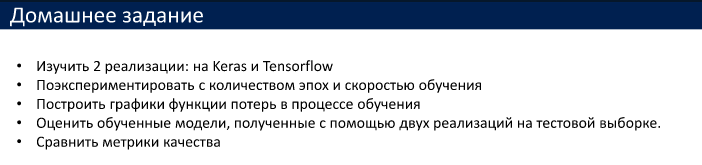

сделано

сделано

сделано

сделано

сделано



Поэкспериментируем с количеством эпох.

Для 5 эпох еще на самой лекции получили такие данные:

Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.2644 - accuracy: 0.9233
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.1057 - accuracy: 0.9688
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0693 - accuracy: 0.9794
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0505 - accuracy: 0.9848
Epoch 5/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0377 - accuracy: 0.9890

Для 3 эпох:

Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 0.2637 - accuracy: 0.9240
Epoch 2/3
469/469 [==============================] - 5s 12ms/step - loss: 0.1069 - accuracy: 0.9684
Epoch 3/3
469/469 [==============================] - 7s 16ms/step - loss: 0.0697 - accuracy: 0.9796

Для 8 эпох:

Epoch 1/8
469/469 [==============================] - 5s 11ms/step - loss: 0.2642 - accuracy: 0.9249
Epoch 2/8
469/469 [==============================] - 6s 12ms/step - loss: 0.1077 - accuracy: 0.9688
Epoch 3/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0704 - accuracy: 0.9793
Epoch 4/8
469/469 [==============================] - 7s 15ms/step - loss: 0.0519 - accuracy: 0.9844
Epoch 5/8
469/469 [==============================] - 7s 15ms/step - loss: 0.0383 - accuracy: 0.9886
Epoch 6/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0299 - accuracy: 0.9913
Epoch 7/8
469/469 [==============================] - 6s 12ms/step - loss: 0.0220 - accuracy: 0.9938
Epoch 8/8
469/469 [==============================] - 8s 16ms/step - loss: 0.0166 - accuracy: 0.9956

In [ ]:
#keras, epochs=3

from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer= "rmsprop",#sgd
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, batch_size=128)

Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 0.2637 - accuracy: 0.9240
Epoch 2/3
469/469 [==============================] - 5s 12ms/step - loss: 0.1069 - accuracy: 0.9684
Epoch 3/3
469/469 [==============================] - 7s 16ms/step - loss: 0.0697 - accuracy: 0.9796


In [ ]:
#keras, epochs=8

from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer= "rmsprop",#sgd
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=8, batch_size=128)

Epoch 1/8
469/469 [==============================] - 5s 11ms/step - loss: 0.2642 - accuracy: 0.9249
Epoch 2/8
469/469 [==============================] - 6s 12ms/step - loss: 0.1077 - accuracy: 0.9688
Epoch 3/8
469/469 [==============================] - 5s 10ms/step - loss: 0.0704 - accuracy: 0.9793
Epoch 4/8
469/469 [==============================] - 7s 15ms/step - loss: 0.0519 - accuracy: 0.9844
Epoch 5/8
469/469 [==============================] - 7s 15ms/step - loss: 0.0383 - accuracy: 0.9886
Epoch 6/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0299 - accuracy: 0.9913
Epoch 7/8
469/469 [==============================] - 6s 12ms/step - loss: 0.0220 - accuracy: 0.9938
Epoch 8/8
469/469 [==============================] - 8s 16ms/step - loss: 0.0166 - accuracy: 0.9956


Tensorflow

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

for epoch in range(1,11,2):
  print("epoch ", epoch)
  fit(model, train_images, train_labels, epochs=epoch, batch_size=128)

  import numpy as np
  predictions = model(test_images)
  predictions = predictions.numpy()
  predicted_labels = np.argmax(predictions, axis=1)
  matches = predicted_labels == test_labels
  print(f"accuracy: {matches.mean():.2f}")
  print("\n")

epoch  1
Epoch 0
loss at batch 0: 0.29
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.41
accuracy: 0.91


epoch  3
Epoch 0
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.41
Epoch 1
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.41
Epoch 2
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.41
accuracy: 0.91


epoch  5
Epoch 0
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.40
Epoch 1
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.31
loss at batch 400: 0.40
Epoch 2
loss at batch 0: 0.27
loss at batch 100: 0.25
loss at batch 200: 0.24
loss at batch 300: 0.30
loss at batch 400: 0.40
Epoch 3
loss at batch 0: 0.27
loss at batch 100: 0.25
los

In [ ]:
error_arr=[]
#for epoch in range(1,11,2):
print("epoch ", epoch)
fit(model, train_images, train_labels, epochs=10, batch_size=128)
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
error_arr.append(tf.reduce_mean(tf.math.square(predicted_labels - test_labels), axis=-1))
print(f"accuracy: {matches.mean():.2f}")
print("\n")

epoch  1
Epoch 0
loss at batch 0: 0.31
loss at batch 100: 0.27
loss at batch 200: 0.26
loss at batch 300: 0.32
loss at batch 400: 0.43
Epoch 1
loss at batch 0: 0.29
loss at batch 100: 0.27
loss at batch 200: 0.26
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 2
loss at batch 0: 0.29
loss at batch 100: 0.27
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 3
loss at batch 0: 0.29
loss at batch 100: 0.27
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 4
loss at batch 0: 0.29
loss at batch 100: 0.27
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 5
loss at batch 0: 0.29
loss at batch 100: 0.27
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 6
loss at batch 0: 0.29
loss at batch 100: 0.26
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at batch 400: 0.42
Epoch 7
loss at batch 0: 0.29
loss at batch 100: 0.26
loss at batch 200: 0.25
loss at batch 300: 0.32
loss at

In [ ]:
#keras, epochs=3
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

(train_images2, train_labels), (test_images, test_labels) = mnist.load_data()
train_images2 = train_images2.reshape((60000, 28 * 28))
train_images2 = train_images2.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
print(train_images2.shape)

model2 = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model2.compile(optimizer= "rmsprop",#sgd
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history =model2.fit(train_images2, train_labels, epochs=3, batch_size=128)


(60000, 784)
Epoch 1/3
469/469 [==============================] - 5s 9ms/step - loss: 0.2665 - accuracy: 0.9229
Epoch 2/3
469/469 [==============================] - 4s 9ms/step - loss: 0.1081 - accuracy: 0.9687
Epoch 3/3
469/469 [==============================] - 8s 17ms/step - loss: 0.0706 - accuracy: 0.9789


In [ ]:
print("Evaluate model on test data")
results = model2.evaluate(test_images, test_labels,batch_size=128)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_images)
print("prediction shape:", prediction.shape)

Evaluate model on test data
79/79 [==============================] - 1s 7ms/step - loss: 0.0731 - accuracy: 0.9770
test loss, test acc: [0.07306276261806488, 0.9769999980926514]
Generate a prediction
313/313 [==============================] - 1s 2ms/step
prediction shape: (10000, 10)


***ГРАФИКИ KERAS***

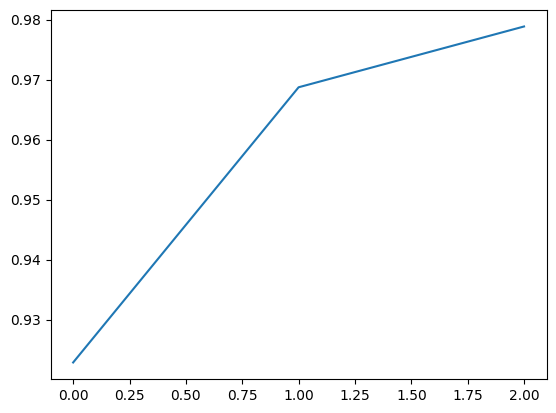

In [ ]:
plt.plot(history.history['accuracy'])

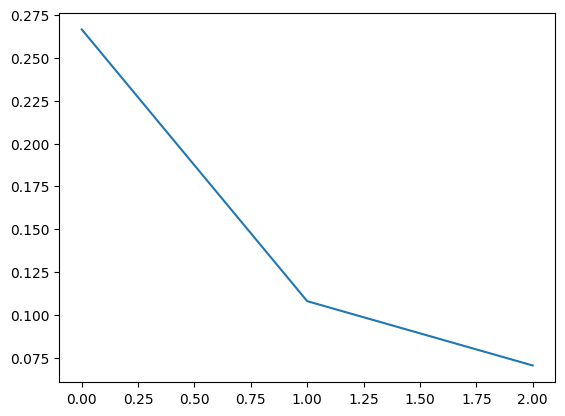

In [ ]:

plt.plot(history.history['loss'])